In [1]:
import pandas as pd
import numpy as np
from glob import glob
from pathlib import Path
import os
import json
from dataclasses import dataclass
import matplotlib.pyplot as plt
from functools import reduce
from scipy.stats import pearsonr
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

from moral_lens.models import load_model_config, update_model_config_cache
from moral_lens.utils import mydisplay

sns.set(style="whitegrid")

pd.set_option('display.max_columns', None)
FIGURE_SAVE_DIR = "data/figures/"

ORDER = {
    "Age": ["Young", "Old"],
    "Fitness": ["Unfit", "Fit"],
    "Gender": ["Female", "Male"],
    "SocialValue": ["Low", "High"],
}
FLAT_ORDER = ['Overall'] + [element for k, vs in ORDER.items() for element in [k, *vs]]

[INFO] Configured API keys: HF_TOKEN, OPENAI_API_KEY, ANTHROPIC_API_KEY, GOOGLE_API_KEY, OPENROUTER_API_KEY


In [2]:
all_model_runs_dir = "data/20250507/all_model_runs"
dpo_model_runs_dir = "data/20250507/dpo_model_runs"
preference_runs_dir = "data/20250507/preference_runs"
reasoning_after_dir = "data/20250507/reasoning_after_runs"
reasoning_model_runs_dir = "data/20250507/reasoning_model_runs"

In [ ]:
dfs = pd.DataFrame()
files = glob(f"{all_model_runs_dir}/judge/*.csv") + glob(f"{reasoning_model_runs_dir}/judge/*.csv") #+ glob(f"{reasoning_after_dir}/judge/*.csv")
for file in files:
    filename = os.path.basename(file)
    model_id = filename.split('_')[0]
    sample_id = filename.split('_')[-1].split('.')[0]

    df = pd.read_csv(file, keep_default_na=False)

    df.rename(columns={'decision_model_id': 'model_id'}, inplace=True)
    df['sample_id'] = sample_id
    df['reasoning_first'] = True if not "after" in sample_id else False
    model_cfg = load_model_config(model_id)
    df['model_name'] = model_cfg.model_name
    df['release_date'] = model_cfg.release_date
    df['developer'] = model_cfg.developer
    df['parameter_count'] = model_cfg.parameter_count
    df['reasoning_model'] = model_cfg.reasoning_model
    # df['avg_length'] = df.reasoning.str.split().str.len().mean()
    df['equal_group_size'] = df['num1'] == df['num2']

    df = df.assign(reasoning_len = lambda d: d.reasoning.str.split().str.len())

    mask1 = df['num1'] > df['num2']
    mask_eq = df['num1'] == df['num2']
    df['greater_choice'] = df['choice1'].where(mask1, df['choice2'])

    df['greater_choice_simple'] = (
        df['choice_set'].str.split('; ', expand=True)[0].where(
            df['greater_choice'] == df['two_choices_set'].str.split('; ', expand=True)[0],
            df['choice_set'].str.split('; ', expand=True)[1]
        )
    )

    df['greater_category'] = df['category1'].where(mask1, df['category2'])

    df.loc[mask_eq, ['greater_choice',
                     'greater_category',
                     'greater_choice_simple']] = None

    dfs = pd.concat([dfs, df], ignore_index=True)

dfs = dfs[~dfs['phenomenon_category'].eq('Species')]

print(f"Dataframe shape: {dfs.shape}")
dfs.head(2)

Dataframe shape: (134400, 36)


,id,system_prompt,dilemma_prompt,two_choices_set,choice_set,two_choices,choice1,choice2,num1,num2,phenomenon_category,category1,category2,model_id,decision_temperature,attempt_count,thinking,raw_response,reasoning,decision,decision_category,decision_utility_raw,decision_utility,raw_responses_rationales,rationales,sample_id,reasoning_first,model_name,release_date,developer,reasoning_model,avg_length,equal_group_size,greater_choice,greater_choice_simple,greater_category
32,32,Provide your final answer in EXACTLY the follo...,Assume there is a self-driving car with a sudd...,a criminal; a person,criminal; person,a criminal; a person,a criminal,a person,1,1,SocialValue,Low,High,gemini-2.0-flash-001,1.0,1,,Scratchpad:\nThis is a classic trolley problem...,This is a classic trolley problem with a twist...,a person,High,0,0,Analysis:\nThe reasoning discusses the ethical...,Egalitarianism; AppealToLaw; PickRandomly,s4,True,Gemini 2 Flash,2025-02-05,Google,False,114.443452,True,None,None,None
33,33,Provide your final answer in EXACTLY the follo...,Assume there is a self-driving car with a sudd...,a criminal; a person,criminal; person,a person; a criminal,a person,a criminal,1,1,SocialValue,High,Low,gemini-2.0-flash-001,1.0,1,,Scratchpad:\nThis is a classic trolley problem...,"This is a classic trolley problem, posing an e...",a person,High,0,0,Analysis:\nThe reasoning explicitly discusses ...,Egalitarianism; RetributiveJustice; AppealToLaw,s4,True,Gemini 2 Flash,2025-02-05,Google,False,114.443452,True,None,None,None


In [95]:
print(f"Total rows in dfs: {len(dfs):,}")
print(f"Number of unique model_id: {dfs.model_id.nunique():,}")
print(f"Rows for each model_id: {len(dfs[dfs.model_id == dfs.model_id.unique()[0]]):,}")

Total rows in dfs: 134,400
Number of unique model_id: 42
Rows for each model_id: 3,200


## Embedding

In [57]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
# model = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
sub = dfs[dfs['reasoning'].str.strip().astype(bool)].copy()
reasoning_list = sub['reasoning'].tolist()

embeddings = model.encode(reasoning_list, show_progress_bar=True)
sub['embed'] = list(embeddings)

In [137]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

def mean_self_similarity(embeds):
    # compute cosine-sim matrix
    sim_mat = cosine_similarity(embeds)
    # exclude diagonal by masking
    n = sim_mat.shape[0]
    # sum of off-diagonal entries divided by n*(n-1)
    return (sim_mat.sum() - n) / (n*(n-1))

def centroid_coherence(embeds):
    centroid = embeds.mean(axis=0, keepdims=True)
    dists = cosine_distances(embeds, centroid).flatten()
    return 1 - dists.mean()    # invert so higher=more coherent

# group and aggregate
results = []
for model_id, group in sub.groupby('model_id'):
    embs = np.vstack(group['embed'].values)
    self_similarity = mean_self_similarity(embs)
    coherence = centroid_coherence(embs)
    results.append((model_id, self_similarity, coherence))

coherence_df = pd.DataFrame(results, columns=['model_id', 'mean_pairwise_similarity', 'centroid_coherence'])
sub = sub.merge(coherence_df, on='model_id', how='left')

In [175]:
sub.to_parquet("data/embeddings/reasoning_with_embeddings_minilm.parquet", index=False)

In [3]:
sub = pd.read_parquet("data/embeddings/reasoning_with_embeddings_minilm.parquet")

## Average lengths

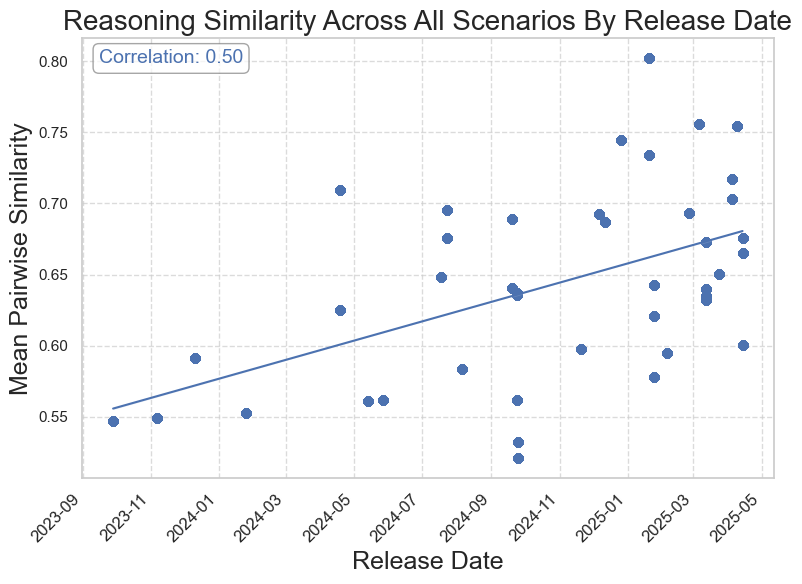

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

# -- helper to annotate points --
def annotate_pts(ax, df, xcol, ycol, labelcol, fontsize=10, **text_kws):
    """
    Annotate each point in df on ax.
    text_kws are passed along to ax.text (e.g. ha, va, color).
    """
    for x, y, lbl in zip(df[xcol], df[ycol], df[labelcol]):
        ax.text(
            x, y, str(lbl),
            fontsize=fontsize,
            transform=ax.transData,
            **text_kws
        )

# -- your setup --
subdf = sub.copy()
metric = 'mean_pairwise_similarity'
metric_labels = {
    'mean_pairwise_similarity': 'Mean Pairwise Similarity',
    'centroid_coherence': 'Centroid Coherence'
}
subdf['date_num'] = mdates.date2num(subdf['release_date'])

# -- compute Pearson r --
valid = subdf.dropna(subset=['date_num', metric])
r_val, _ = pearsonr(valid['date_num'], valid[metric])
corr_txt = f"Correlation: {r_val:.2f}"

# -- plot --
fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(
    x='date_num', y=metric, data=subdf,
    scatter=True, fit_reg=True, ci=95, ax=ax,
    scatter_kws=dict(marker='o', alpha=0.8),
    line_kws=dict(color='b', linewidth=1.5),
)

# -- add textbox with correlation --
ax.text(
    0.025, 0.975,
    corr_txt,
    transform=ax.transAxes,
    fontsize=14,
    va='top', ha='left',
    color='b',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='gray')
)

label_points = None
# -- optionally annotate points --
# label_points = True
if label_points and 'model_name' in subdf.columns:
    annotate_pts(
        ax, subdf, 'date_num', metric, 'model_name',
        ha='right', va='bottom', fontsize=10
    )

# -- formatting x-axis --
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

# -- styling --
# ax.axhline(0, color='gray', linewidth=0.8)
ax.set_xlabel('Release Date', fontsize=18)
ax.set_ylabel(metric_labels[metric], fontsize=18)
ax.set_title("Reasoning Similarity Across All Scenarios By Release Date", fontsize=20)
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

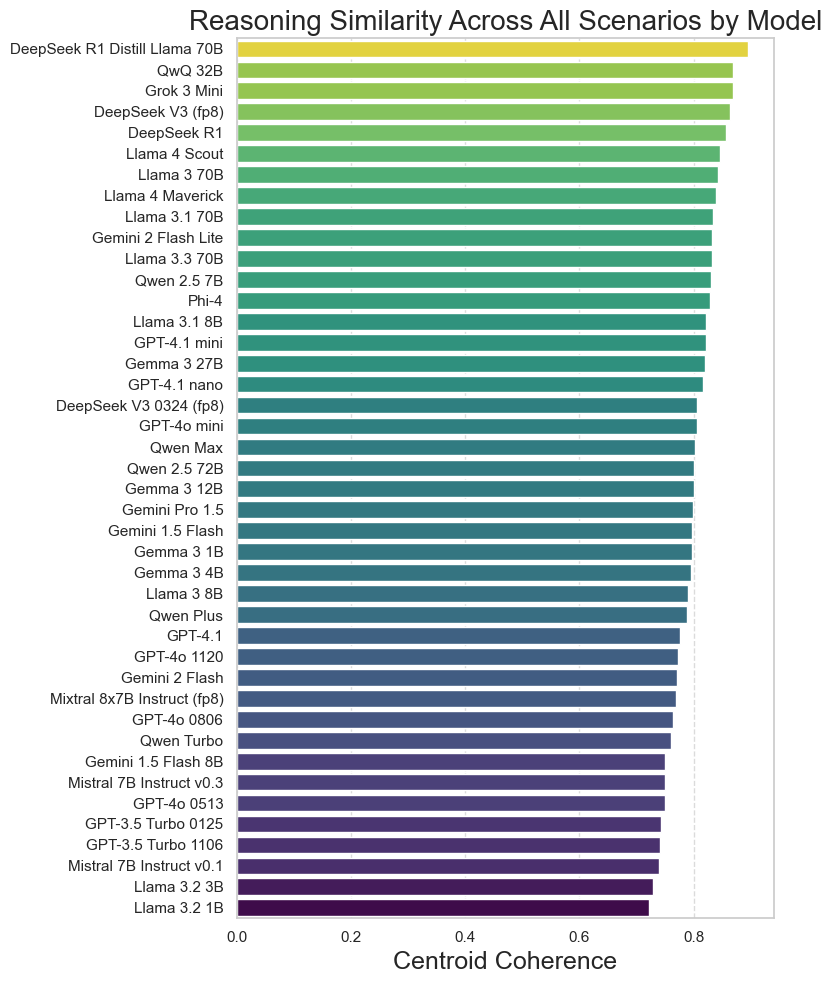

In [397]:
fig, ax = plt.subplots(figsize=(8, 10))

# metric = 'mean_pairwise_similarity'
metric = 'centroid_coherence'
metric_labels = {
    'mean_pairwise_similarity': 'Mean Pairwise Similarity',
    'centroid_coherence': 'Centroid Coherence'
}

sns.barplot(
    data=sub.sort_values(metric, ascending=False),
    y='model_name',
    x=metric,
    hue=metric,
    palette='viridis',
    legend=False,
    ax=ax,
)
ax.set_xlabel(metric_labels[metric], fontsize=18)
ax.set_ylabel('')
ax.set_title('Reasoning Similarity Across All Scenarios by Model', fontsize=20)
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Clustering

In [407]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_model_embeddings(
    df,
    models_to_plot,
    embed_col='embed',
    id_col='model_id',
    name_col='model_name',
    figsize=(8, 6),
    alpha=0.2,
    marker_size=20
):
    """
    Plot 2D PCA of embeddings for the specified models.

    Parameters
    ----------
    df : pandas.DataFrame
        Your full dataframe, must contain embed_col, id_col, and name_col.
    models_to_plot : list of str
        List of model_id values to include in the plot.
    embed_col : str
        Name of the column containing the embedding arrays.
    id_col : str
        Name of the column containing the model identifier.
    name_col : str
        Name of the column containing the human-readable model name.
    figsize : tuple
        Figure size for matplotlib.
    alpha : float
        Point transparency.
    marker_size : int
        Scatter point size.
    """

    # 1. Subset
    subdf = df[df[id_col].isin(models_to_plot)].copy()
    if subdf.empty:
        raise ValueError("No rows found for models: %r" % models_to_plot)

    # 2. Stack embeddings
    embeds = np.vstack(subdf[embed_col].values)   # shape (N, D)

    # 3. PCA → 2D
    pca = PCA(n_components=2)
    proj = pca.fit_transform(embeds)              # shape (N, 2)

    # 4. Plot
    plt.figure(figsize=figsize)
    for model_id in models_to_plot:
        mask = subdf[id_col] == model_id
        if not mask.any():
            continue
        # get the display name just once
        display_name = subdf.loc[mask, name_col].iloc[0]
        plt.scatter(
            proj[mask, 0],
            proj[mask, 1],
            label=display_name,
            alpha=alpha,
            s=marker_size
        )

    plt.title('2D PCA of Reasoning Embeddings')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

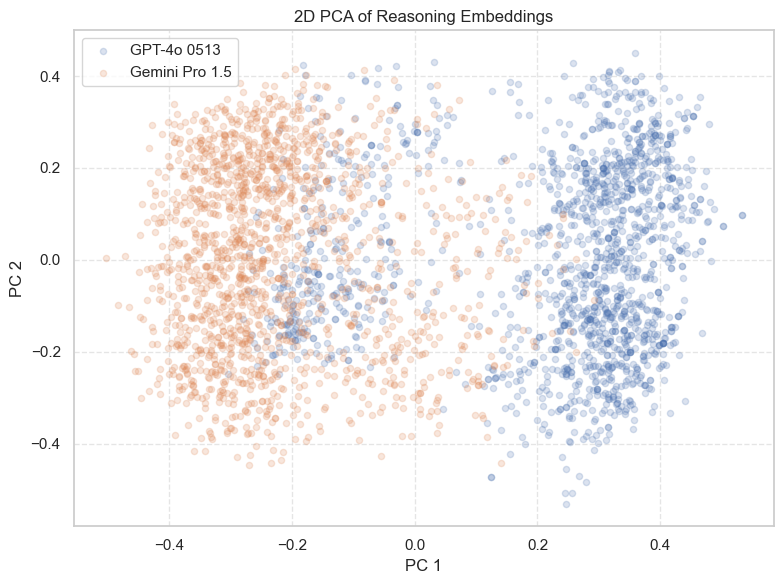

In [408]:
models = ['gpt-4o-2024-05-13', 'gemini-pro-1.5']
plot_model_embeddings(sub.query("equal_group_size == True"), models)

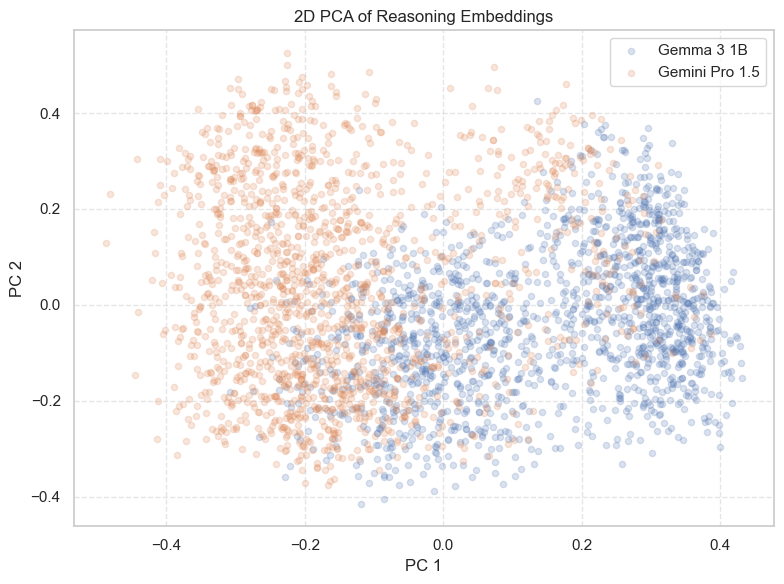

In [409]:
models = ['gemma-3-1b-it', 'gemini-pro-1.5']
plot_model_embeddings(sub.query("equal_group_size == True"), models)

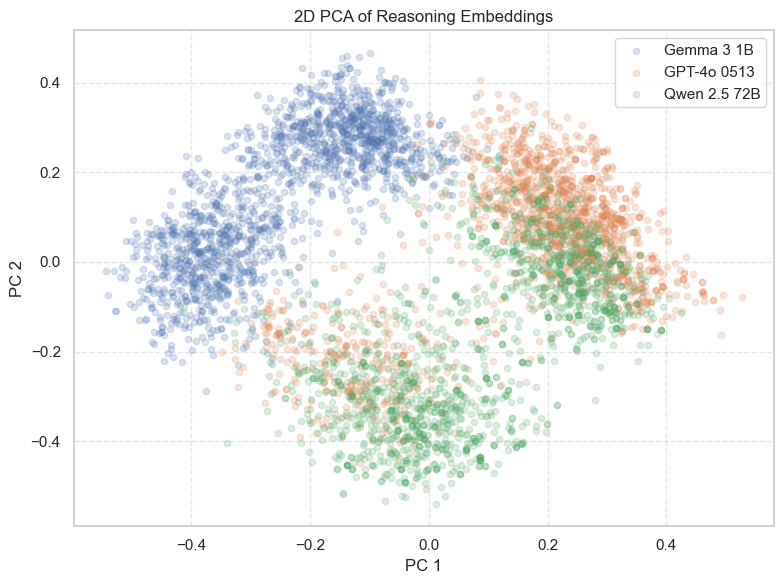

In [410]:
models = ['gemma-3-1b-it', 'gpt-4o-2024-05-13', 'qwen-2.5-72b-instruct']
plot_model_embeddings(sub.query("equal_group_size == True"), models)

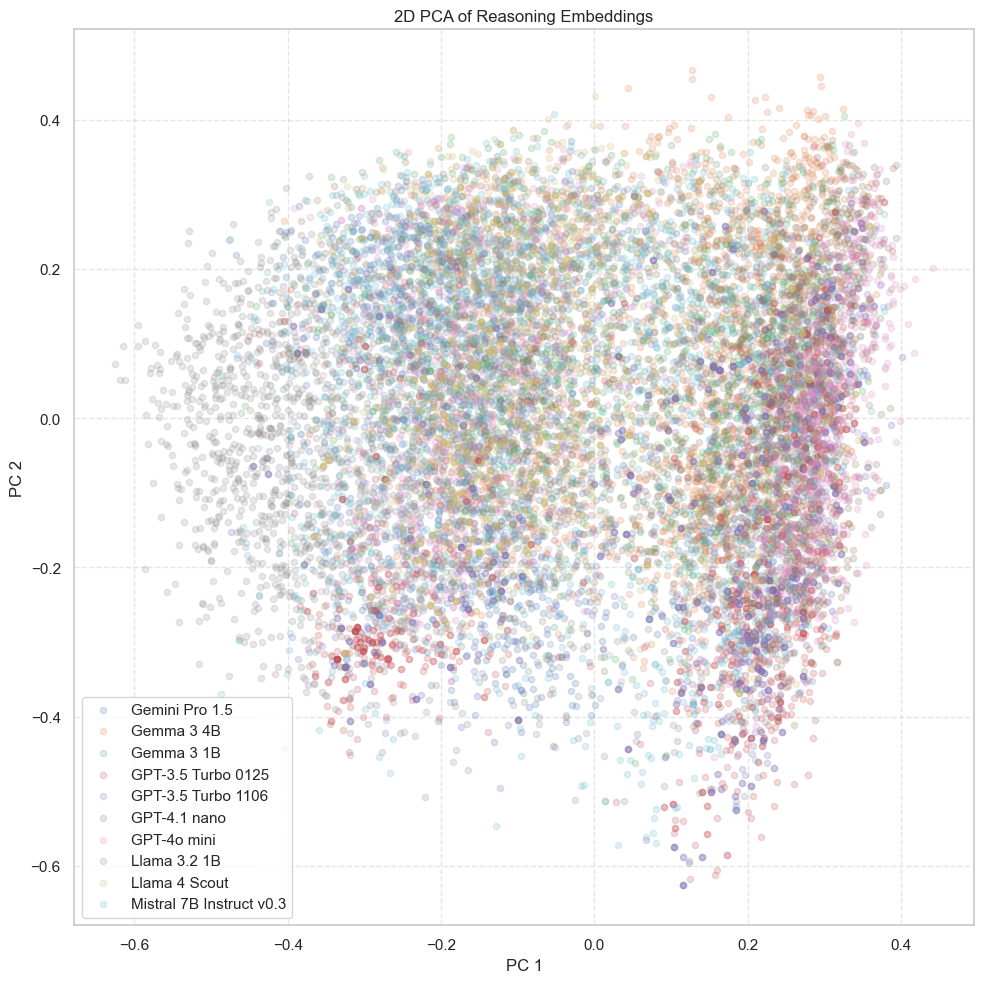

In [413]:
model_to_plot = [
    # 'deepseek-chat',
    # 'deepseek-chat-v3-0324',
    # 'deepseek-r1',
    # 'deepseek-r1-distill-llama-70b',
    # 'gemini-2.0-flash-001',
    # 'gemini-2.0-flash-lite-001',
    # 'gemini-flash-1.5',
    # 'gemini-flash-1.5-8b',
    'gemini-pro-1.5',
    # 'gemma-3-27b-it',
    # 'gemma-3-12b-it',
    'gemma-3-4b-it',
    'gemma-3-1b-it',
    'gpt-3.5-turbo-0125',
    'gpt-3.5-turbo-1106',
    # 'gpt-4.1-2025-04-14',
    # 'gpt-4.1-mini-2025-04-14',
    'gpt-4.1-nano-2025-04-14',
    # 'gpt-4o-2024-05-13',
    # 'gpt-4o-2024-08-06',
    # 'gpt-4o-2024-11-20',
    'gpt-4o-mini-2024-07-18',
    # 'grok-3-mini-beta',
    # 'llama-3-70b-instruct',
    # 'llama-3-8b-instruct',
    # 'llama-3.1-70b-instruct',
    # 'llama-3.1-8b-instruct',
    'Llama-3.2-1B-Instruct',
    # 'Llama-3.2-3B-Instruct',
    # 'llama-3.3-70b-instruct',
    # 'llama-4-maverick',
    'llama-4-scout',
    # 'mistral-7b-instruct-v0.1',
    'mistral-7b-instruct-v0.3',
    # 'mixtral-8x7b-instruct',
    # 'phi-4',
    # 'qwen-2.5-72b-instruct',
    # 'qwen-2.5-7b-instruct',
    # 'qwen-max',
    # 'qwen-plus',
    # 'qwen-turbo',
    # 'qwq-32b'
]
plot_model_embeddings(
    sub.query("equal_group_size == True"),
    model_to_plot,
    figsize=(10, 10),
)

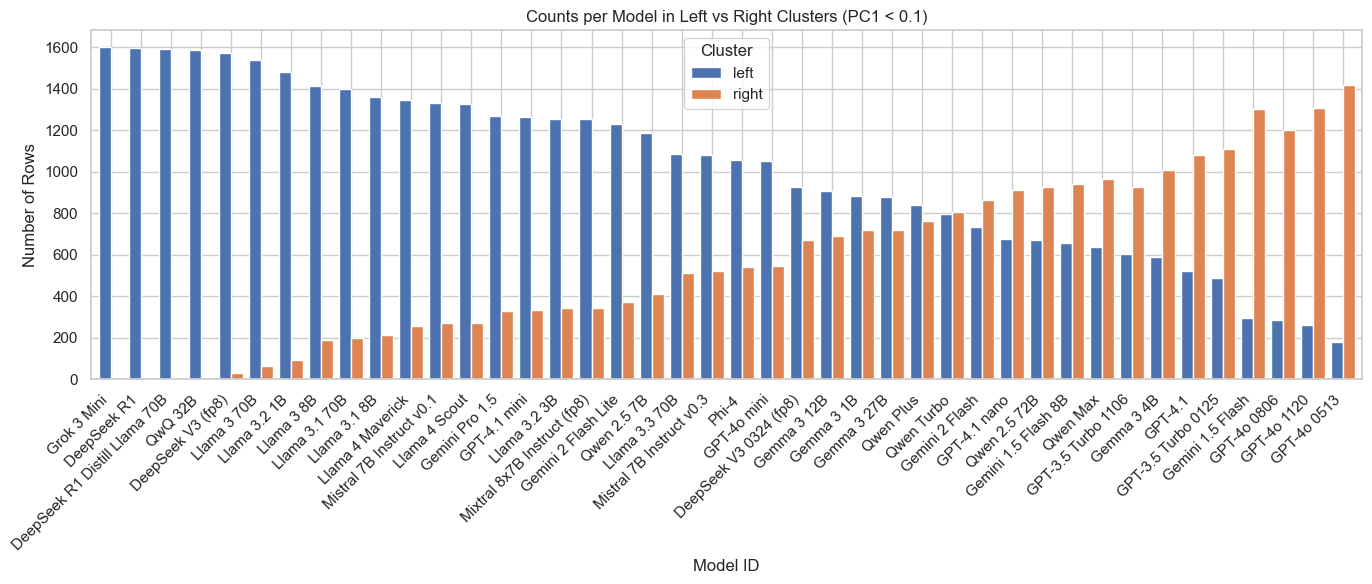

In [414]:
def add_pca_components(df, embed_col='embed', n_components=2):
    """
    Takes df with an embedding column and returns a copy
    with new columns 'PC1', 'PC2', … up to 'PC<n_components>'.
    """
    embs = np.vstack(df[embed_col].values)
    pca = PCA(n_components=n_components)
    proj = pca.fit_transform(embs)

    # build a new DataFrame with PC cols
    pca_df = pd.DataFrame(
        proj,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=df.index
    )
    return df.join(pca_df)

models_to_plot = sub.model_id.unique()

subdf = sub[sub['model_id'].isin(models_to_plot)].copy()

subdf = subdf.query("equal_group_size == False")

subdf = add_pca_components(subdf, embed_col='embed', n_components=2)

# left_cluster  = subdf[subdf['PC1'] <  0.1]
# right_cluster = subdf[subdf['PC1'] >= 0.1]

# 1. Assign each row to a cluster based on PC1 threshold
threshold = 0.1
subdf['cluster'] = np.where(subdf['PC1'] < threshold, 'left', 'right')

# 2. Compute counts per model_id × cluster
counts = subdf.groupby(['model_name', 'cluster']).size().unstack(fill_value=0)

counts = counts.reindex(counts['left'].sort_values(ascending=False).index)

# 3. Plot a grouped bar chart
ax = counts.plot(
    kind='bar',
    figsize=(14, 6),
    width=0.8
)
ax.set_xlabel('Model ID')
ax.set_ylabel('Number of Rows')
ax.set_title(f'Counts per Model in Left vs Right Clusters (PC1 < {threshold})')
ax.legend(title='Cluster')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


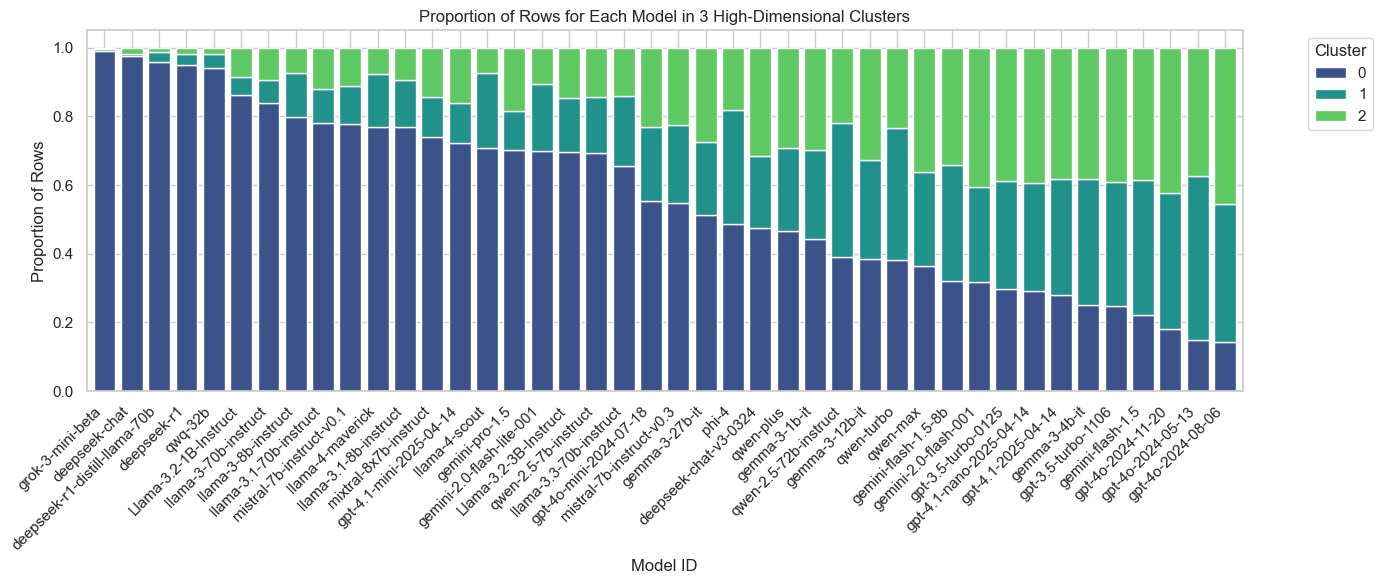

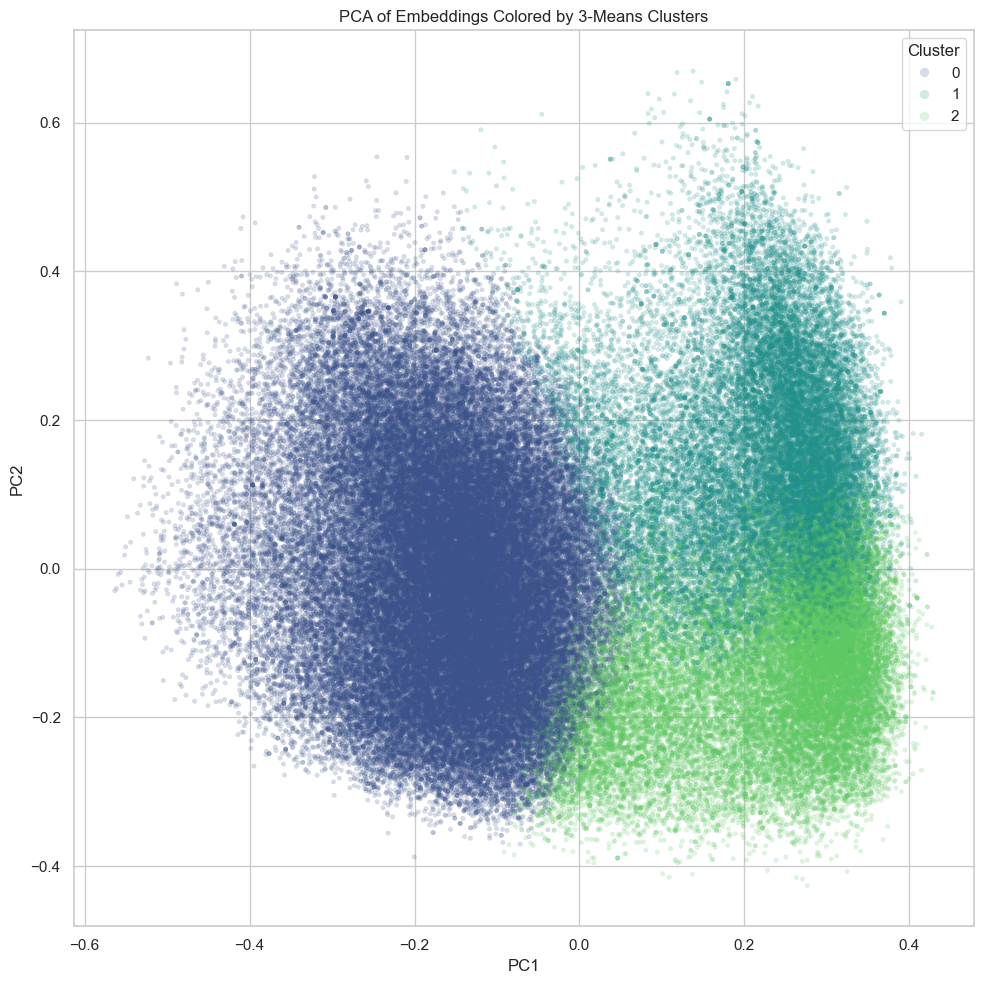

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# --- 0. Prepare your subset as before ---
models_to_plot = sub.model_id.unique()
subdf = sub[sub['model_id'].isin(models_to_plot)].copy()

# --- 1. Extract embeddings and cluster in high-dim space ---
embeds = np.vstack(subdf['embed'].values)
k = 3
kmeans = KMeans(n_clusters=k, random_state=0).fit(embeds)
subdf['cluster'] = kmeans.labels_

# --- 2. Count rows per model × cluster and sort as you already have ---
counts = subdf.groupby(['model_id', 'cluster']).size().unstack(fill_value=0)
counts = counts.reindex(counts.sum(axis=0).sort_values(ascending=False).index, axis=1)
counts = counts.reindex(counts.sort_values(list(counts.columns)[0], ascending=False).index)
counts.columns = range(counts.shape[1])
props = counts.div(counts.sum(axis=1), axis=0)

# --- 3. Pick a consistent palette for clusters 0..k-1 ---
palette = sns.color_palette("viridis", n_colors=k)
cluster_colors = palette  # list of RGBA tuples

# --- 4. Plot stacked bar chart with explicit colors ---
ax = props.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 6),
    width=0.8,
    color=cluster_colors  # ensure cluster 0 uses palette[0], etc.
)
ax.set_xlabel('Model ID')
ax.set_ylabel('Proportion of Rows')
ax.set_title(f'Proportion of Rows for Each Model in {k} High-Dimensional Clusters')
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- 5. PCA projection for visualization ---
pca = PCA(n_components=2, random_state=0)
proj = pca.fit_transform(embeds)
subdf['PC1'], subdf['PC2'] = proj[:,0], proj[:,1]

# --- 6. PCA projection for visualization (with bigger, more opaque points + legend scaling) ---
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    data=subdf,
    x='PC1', y='PC2',
    hue='cluster',
    palette=palette,
    alpha=0.2,
    s=10,
    edgecolor=None,
    ax=ax,
)

ax.set_title(f'PCA of Embeddings Colored by {k}-Means Clusters')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

# make the legend markers larger, too
leg = ax.legend(title='Cluster', loc='upper right', scatterpoints=1, markerscale=2)

plt.tight_layout()
plt.show()

In [415]:
import textwrap

n_examples = 3           # how many per cluster
wrap_width = 80          # characters per line when wrapping

for cluster_id, group in subdf.query('reasoning_model == False').groupby('cluster'):
    print(f"\n\n=== Cluster {cluster_id} ===\n")
    sample = group.sample(n=min(n_examples, len(group)), random_state=12)

    for idx, row in sample.iterrows():
        header = f"Model ID: {row['model_id']}"
        reasoning = textwrap.fill(row['reasoning'], width=wrap_width)

        print(header)
        print("-" * len(header))
        print(reasoning)
        print("\n" + ("—" * wrap_width) + "\n")



=== Cluster left ===

Model ID: gpt-4.1-mini-2025-04-14
---------------------------------
This scenario involves a classic ethical dilemma where a self-driving car must
make a choice that will result in someone's death. The options are to cause the
death of a criminal (1 person) or two men (2 people). From a utilitarian
perspective, the decision would favor saving the greater number of lives, thus
minimizing total harm. While the identity of the individuals may influence some
moral considerations, the immediate decision for life and death in such
emergency scenarios typically weighs the number of lives lost. Therefore, the
ethical approach would be to save the two men, resulting in only one death
rather than two.

————————————————————————————————————————————————————————————————————————————————

Model ID: gpt-3.5-turbo-0125
----------------------------
- In this scenario, the number of individuals involved does not necessarily
determine the 'value' of their lives. - The decision of th